# Workshop on Bayesian Networks
A workshop for Bayesian Networks, PyAgrum, and related tools to construct, save, analysis the Bayesian Networks and use it for causal analysis in vehicle related applications.



## Useful Tools for Bayesian Network Programming

- GeNIe: https://www.bayesfusion.com/genie/

GeNIe Modeler is a graphical user interface (GUI) to SMILE Engine and allows for interactive model building and learning. 


- Agrum and PyAgrum:
pyAgrum is a scientific C++ and Python library dedicated to Bayesian networks (BN) and other Probabilistic Graphical Models. Based on the C++ aGrUM library, it provides a high-level interface to the C++ part of aGrUM allowing to create, manage and perform efficient computations with Bayesian networks and others probabilistic graphical models : Markov random fields (MRF), influence diagrams (ID) and LIMIDs, credal networks (CN), dynamic BN (dBN), probabilistic relational models (PRM).
https://pyagrum.readthedocs.io/en/1.8.3/

## Configurations

- Use local conda environment

```
conda install -c conda-forge pyagrum
```

- Or use Google Collab:

```
pip install pyagrum
```

In [47]:
import matplotlib.pyplot as plt
import os

## Using pyAgrum
import pyAgrum as gum   
import pyAgrum.lib.notebook as gnb   # for display purpose
gnb.configuration()

In [48]:
# Create a Simple BN:
simple_bn = gum.BayesNet('VehicleMonitor')
print(simple_bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0, mem: 0o}


In [49]:
## Create the variables
## pyAgrum(aGrUM) provides 4 types of variables :
# LabelizedVariable
# RangeVariable
# IntegerVariable
# DiscretizedVariable

ws = simple_bn.add(gum.LabelizedVariable('ws','WindSpeed',2))

# to make it more compact
rk, vs = [simple_bn.add(name, 2) for name in ["road_k", "veh_shift"] ] #bn.add(name, 2) === bn.add(gum.LabelizedVariable(name, name, 2))
print (ws, rk, vs)
print (simple_bn)

0 1 2
BN{nodes: 3, arcs: 0, domainSize: 8, dim: 3, mem: 48o}


In [50]:
# Create the arcs
# simple_bn.AddArc(ws, vs)

# simple_bn.AddArc(rk, vs)

# or equivalently
for link in [(ws, vs), (rk, vs)]:
    simple_bn.addArc(*link)
print(simple_bn)

BN{nodes: 3, arcs: 2, domainSize: 8, dim: 6, mem: 96o}


In [51]:
simple_bn

(pyAgrum.BayesNet<double>@0x1ff357dbc00) BN{nodes: 3, arcs: 2, domainSize: 8, dim: 6, mem: 96o}

In [52]:
## Create the probability Tables
simple_bn.cpt(ws).fillWith([0.8,0.2])    # remember : c =  0

(pyAgrum.Potential<double>@0x1ff385961c0) 
  ws               |
0        |1        |
---------|---------|
 0.8000  | 0.2000  |

In [53]:
print(simple_bn.cpt("ws")[1])

0.2


In [54]:
# We can also use dictionary to update the conditional probability table
simple_bn.cpt("veh_shift")[{'ws': 0, 'road_k': 0}] = [1-1e-4, 1e-4]
simple_bn.cpt("veh_shift")[{'ws': 0, 'road_k': 1}] = [0.7, 0.3]
simple_bn.cpt("veh_shift")[{'ws': 1, 'road_k': 0}] = [0.6, 0.4]
simple_bn.cpt("veh_shift")[{'ws': 1, 'road_k': 1}] = [0.01, 0.99]
simple_bn.cpt("veh_shift")

(pyAgrum.Potential<double>@0x1ff38596600) 
             ||  veh_shift        |
ws    |road_k||0        |1        |
------|------||---------|---------|
0     |0     || 0.9999  | 0.0001  |
1     |0     || 0.6000  | 0.4000  |
0     |1     || 0.7000  | 0.3000  |
1     |1     || 0.0100  | 0.9900  |

In [55]:
# Save and Load the BN:
gum.saveBN(simple_bn,"out/VehicleMonitor.bif") #bif, dsl, xdsl, bifxml

bn_load=gum.loadBN("out/VehicleMonitor.bif")

## Inference in Bayesian Network

**Exact Inference**
- Lazy propagation reduces the space complexity from HUGIN inference. Multiply Sectioned Bayesian Networks extend Bayesian Networks a cooperative multiagent paradigm.
- Variable Elimination (https://en.wikipedia.org/wiki/Variable_elimination)
- ShaferShenoy Method:  the sum product of a junction tree (Junction tree algorithm) 

In [57]:
## Inference in the Bayesian Network

# Exact inference: 
# - gum.LazyPropagation: transforms the Bayesian network into a hypergraph and propagate the values
#  - gum.VariableElimination
# - gum.ShaferShenoy


# Sampling Inference:
# - gum.GibbsSampling

# define inference engine:
ie=gum.LazyPropagation(simple_bn)  


## If we do not specify the following, it will fail
simple_bn.cpt(ws).fillWith([0.8,0.2])    # remember : c =  0
simple_bn.cpt(rk).fillWith([0.8,0.2])    # remember : c =  0
# Inference without evidence:
ie.makeInference()
print (ie.posterior("veh_shift"))




  veh_shift        |
0        |1        |
---------|---------|
 0.8483  | 0.1517  |



In [58]:
ie=gum.GibbsSampling(simple_bn)  

# Inference without evidence:
ie.makeInference()
print (ie.posterior("ws"))
print (ie.posterior("veh_shift"))


  ws               |
0        |1        |
---------|---------|
 0.8433  | 0.1567  |


  veh_shift        |
0        |1        |
---------|---------|
 0.9067  | 0.0933  |



In [59]:
# Inference without evidence
from IPython.core.display import HTML


HTML(f"In our BN, $P(vehShift)=${ie.posterior('veh_shift')[:]}")

In [60]:
# Inference with evidence 
ie=gum.LazyPropagation(simple_bn)  
ie.setEvidence({ws:0, rk: 0})  # set hard evidence on both ws and rk nodes
ie.makeInference()
ie.posterior("veh_shift")

(pyAgrum.Potential<double>@0x1ff3803dbb0) 
  veh_shift        |
0        |1        |
---------|---------|
 0.9999  | 0.0001  |

In [61]:
#Inference with soft evidence
ie.setEvidence({ws: [0.5, 1], rk: [1, 0]}) # we have 50% knowledge on ws is 1, and 100% knowledge on rk is 0
ie.makeInference()
ie.posterior("veh_shift")

(pyAgrum.Potential<double>@0x1ff385964e0) 
  veh_shift        |
0        |1        |
---------|---------|
 0.8666  | 0.1334  |

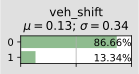

In [62]:
gnb.showProba(ie.posterior("veh_shift"))

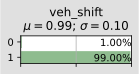

In [63]:
gnb.showPosterior(simple_bn,{ws:1,rk:1},'veh_shift')

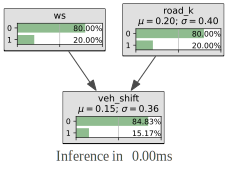

In [64]:
# Inference in the whole Bayesian Net
gnb.showInference(simple_bn,evs={})

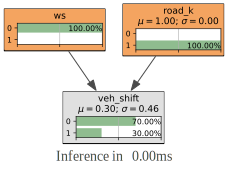

In [65]:
# Inference with Hard evidence
gnb.showInference(simple_bn,evs={rk:1,ws:0})

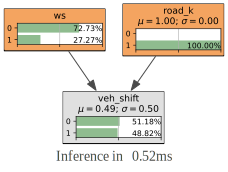

In [66]:
# Inference with soft and hard evidence

gnb.showInference(simple_bn,evs={rk:1, ws:[0.6,0.9]})  # ws is range from 0.6-0.9 

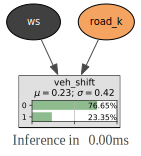

In [67]:
# Inference with Partial Targets

gnb.showInference(simple_bn,evs={rk:[0.3,0.9]},targets={'veh_shift'})

# Bayesian Learning
- Structure Learning
- Parameter Learning

In [32]:
# Bayesian Learning
simple_bn

(pyAgrum.BayesNet<double>@0x1ff357cf7f0) BN{nodes: 3, arcs: 2, domainSize: 8, dim: 6, mem: 96o}

In [68]:


gum.generateSample(simple_bn,1000,"out/simple_monitor.csv",False);

In [69]:
with open("out/simple_monitor.csv","r") as src:
    for _ in range(10):
        print(src.readline(),end="")

ws,veh_shift,road_k
0,0,0
0,0,0
0,0,0
0,0,0
0,0,1
1,1,1
0,0,0
0,0,0
0,0,0


In [70]:
learner=gum.BNLearner("out/simple_monitor.csv",simple_bn) #using bn as template for variables
print(learner)

Filename       : out/simple_monitor.csv
Size           : (1000,3)
Variables      : ws[2], road_k[2], veh_shift[2]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -



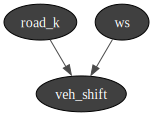

In [71]:
learner=gum.BNLearner("out/simple_monitor.csv",simple_bn) #using bn as template for variables and labels
bn2=learner.learnParameters(simple_bn.dag())
gnb.showBN(bn2)

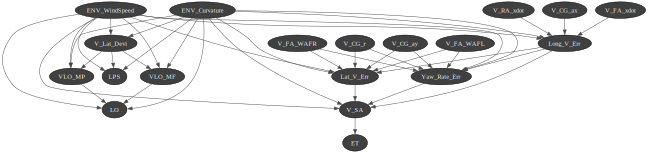

In [39]:
## Use of new Data
bn=gum.loadBN("models/BN_Model_v1_3_2.dsl")
gnb.showBN(bn,size='9')

# This is the base Bayesian network with pre-defined structure

### Structural Learning with MIIC

MIIC (Multivariate Information based Inductive Causation) combines constraint-based and information-theoretic approaches to disentangle direct from indirect effects amongst correlated variables, including cause-effect relationships and the effect of unobserved latent causes.

Starting from a complete graph, the method iteratively removes dispensable edges, by uncovering significant information contributions from indirect paths, and assesses edge-specific confidences from randomization of available data. The remaining edges are then oriented based on the signature of causality in observational data.

More details: https://search.r-project.org/CRAN/refmans/miic/html/miic.html

In [42]:
bn_learner=gum.BNLearner("./data/BN_init_data.csv")

bn2=bn_learner.useMIIC().learnBN()
currentTime=bn_learner.currentTime()

gnb.flow.add(gnb.getBN(bn2,size="9"),f"Learned in {currentTime:.3f}s")
gnb.flow.display()

In [43]:
import pyAgrum.lib.bn_vs_bn as bnvsbn
gnb.flow.add(gnb.getBNDiff(bn,bn2,size="8!"),"Diff with MIIC")
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.display()

## Structural Learning with Greedy Hill Climbing

Simplest heuristic local search 

**Start with a given network** 
- empty network
- a random network

*At each iteration* 
- Evaluate all possible changes
- Apply change that leads to best improvement in score

*Reiterate* 
**Stop when no modification improves score**s score


In [74]:
# use non-local mean correction to adjust the local search

bn3=bn_learner.useGreedyHillClimbing().useNMLCorrection().useScoreBDeu().learnBN()
gnb.flow.add(gnb.getBNDiff(bn,bn3,size="8!"),"Diff with GHC/NMD/BDEU")
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.display()

In [73]:
import pyAgrum.lib.explain as explain

gnb.flow.row(bn,bn3,explain.getInformation(bn3),captions=["Original BN","Learned BN","information"])

In [75]:
bn4=bn_learner.useGreedyHillClimbing().useNMLCorrection().useScoreBDeu().setInitialDAG(bn2.dag()).learnBN()
gnb.flow.add(gnb.getBNDiff(bn,bn4,size="8!"),"Diff with GHC/NMD/BDEU with intial DAG from MIIC")
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.display()

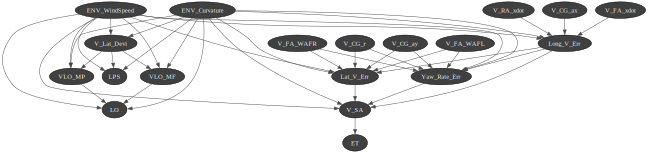

In [76]:
bn5_0=gum.loadBN("models/BN_Model_v1_4.dsl")
gnb.showBN(bn,size='9')

In [77]:
bn_learner_test = gum.BNLearner("./data/BN_test_data.csv")

bn5=bn_learner_test.useGreedyHillClimbing().useNMLCorrection().useScoreBDeu().learnBN()
currentTime=bn_learner.currentTime()

gnb.flow.add(gnb.getBN(bn5,size="9"),f"Learned in {currentTime:.3f}s")
gnb.flow.display()

In [78]:
gnb.flow.add(gnb.getBNDiff(bn5_0,bn5,size="8!"),"Diff with GHC/NMD/BDEU")
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.display()

In [79]:
import pyAgrum.lib.explain as explain

gnb.flow.row(bn5_0,bn5,explain.getInformation(bn5),captions=["Original BN","Learned BN","information"])

In [82]:
print(bn5.variableFromName("Lat_V_Err"))
print(bn5.variableFromName("Yaw_Rate_Err"))

# test with structure learning with init_data
from pyAgrum.lib.bn2roc import showROC
from pyAgrum.lib.bn2roc import showPR
from pyAgrum.lib.bn2roc import showROC_PR

#showROC(bn2,"./out/learn_BN.csv",'Lat_V_Err','False',show_progress=False)
#showROC(bn2,"./data/BN_init_data.csv",'Lat_V_Err','True',show_progress=False)
showROC(bn2,"./data/BN_test_data.csv",'Lat_V_Err','True',show_progress=False)

Lat_V_Err:Labelized({FALSE|TRUE})
Yaw_Rate_Err:Labelized({FALSE|TRUE})


NotFound: [pyAgrum] Object not found: No element with the key <Lat_V_Err>

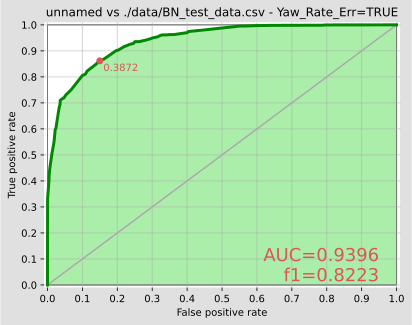

(0.9396402405994468, 0.38718364635, 0.9183070241481449, 0.40546075589999997)

In [83]:
showROC(bn5,"./data/BN_test_data.csv",'Yaw_Rate_Err','TRUE',show_progress=False)

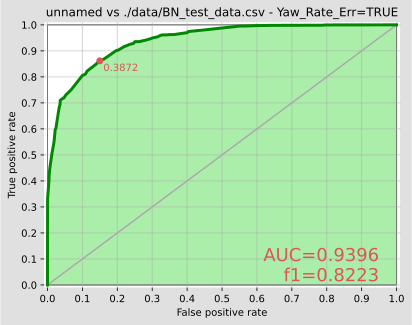

(0.9396402405994468, 0.38718364635, 0.9183070241481449, 0.40546075589999997)

In [84]:
showROC(bn5,"./data/BN_test_data.csv",'Yaw_Rate_Err','TRUE',show_progress=False)

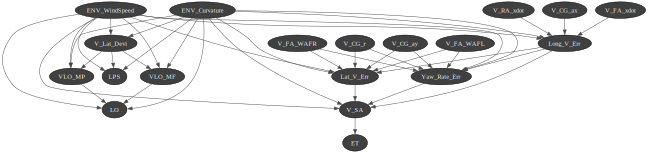

# iterations : 2


In [85]:
## Parametric Learning

# Parametric Learning with the same graph
bn=gum.loadBN("models/BN_Model_v1_4.dsl")
gnb.showBN(bn,size='9')

data_EM = "./data/BN_test_data.csv"

learner = gum.BNLearner(data_EM,bn)
learner.useEM(1e-3)
learner.useSmoothingPrior()

bn_parametric=learner.learnParameters(bn.dag())
print(f"# iterations : {learner.nbrIterations()}")
gnb.flow.row(gnb.getInference(bn),gnb.getInference(bn_parametric))

In [87]:
# DBN
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

twodbn=gum.fastBN("v_latt<-v_lat0->trigger_lat_offsett[2]<-trigger_lat_offset0<-steering_trigger0->steering_triggert;steering_trigger0->v_latt; v_lat0->trigger_lat_offset0")
twodbn

(pyAgrum.BayesNet<double>@0x1ff383aafd0) BN{nodes: 6, arcs: 7, domainSize: 64, dim: 16, mem: 256o}

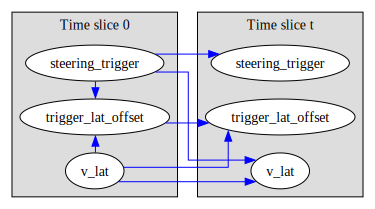

In [88]:
gdyn.showTimeSlices(twodbn)

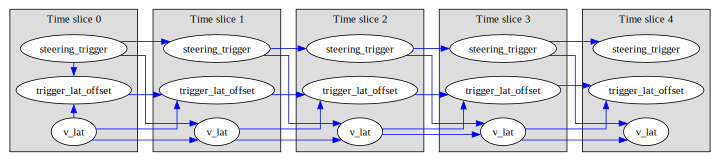

In [90]:
#A dBN is ‘unrolled’ using the 2TBN and the time period size.
# Stationary DBN
T=5

dbn=gdyn.unroll2TBN(twodbn,T)
gdyn.showTimeSlices(dbn,size="10")

In [ ]:
# We can infer on bn just as on a normal bn. Following the naming convention in 2TBN, the variables in a dbN are named using the convention 


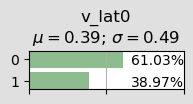
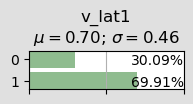
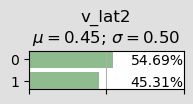
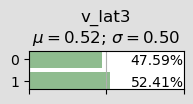
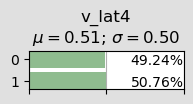

In [91]:
gnb.flow.clear()
for i in range(T):
    gnb.flow.add_html(gnb.getPosterior(dbn,target="v_lat{}".format(i),evs={}),"$P(v_l{})$".format(i))
gnb.flow.display()

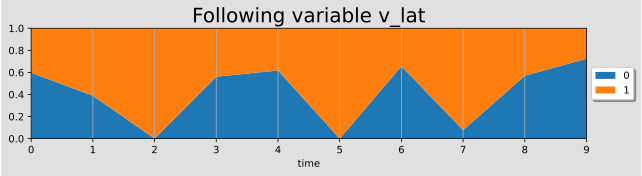

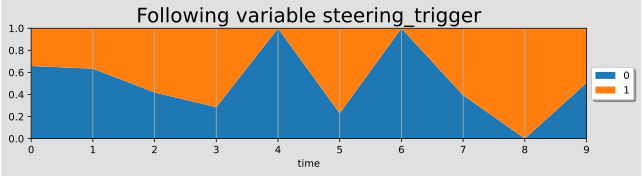

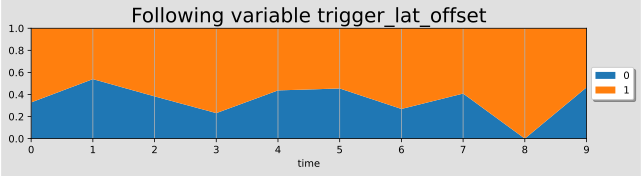

In [92]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 2)
gdyn.plotFollow(["v_lat","steering_trigger", "trigger_lat_offset"],twodbn,T=10,evs={'v_lat2':1,'steering_trigger4':0,'steering_trigger6':0,'steering_trigger8':1,'v_lat5':1,'trigger_lat_offset8':1})

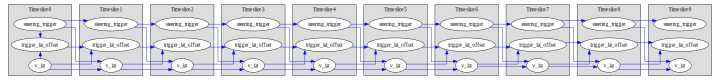

In [93]:
# Nonstationary DBN:
twodbn=gum.fastBN("v_latt<-v_lat0->trigger_lat_offsett[2]<-trigger_lat_offset0<-steering_trigger0->steering_triggert;steering_trigger0->v_latt; v_lat0->trigger_lat_offset0")
twodbntwodbn=gum.fastBN("v_latt<-v_lat0->trigger_lat_offsett[2]<-trigger_lat_offset0<-steering_trigger0->steering_triggert;steering_trigger0->v_latt; v_lat0->trigger_lat_offset0")
twodbn
T=10

dbn=gdyn.unroll2TBN(twodbn,T)
gdyn.showTimeSlices(dbn,size="10")

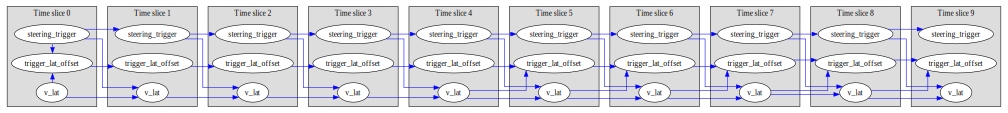

In [94]:
# Non-stationnaty DBN allows to express that the dBN do not follow the same 2TBN during all steps. A unrolled dbn is a classical BayesNet and then can be changed as you want after unrolling.


nsdbn =dbn

# from steps 1 to 5, $trigger_lat_offset t$ only depends on $trigger_lat_offset{t-1}$ and follows this new CPT
for i in range(1,5):
    nsdbn.eraseArc(f"v_lat{i-1}",f"trigger_lat_offset{i}")
   # dbn.cpt(f"c{i}").fillWith(pot,["ct","c0"]) # ct in pot <- first var of cpt, c0 in pot<-second var in cpt

gdyn.showTimeSlices(nsdbn,size="14")

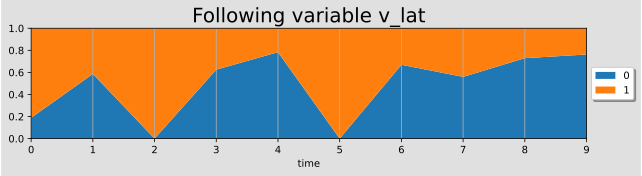

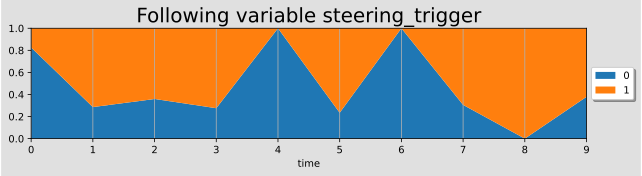

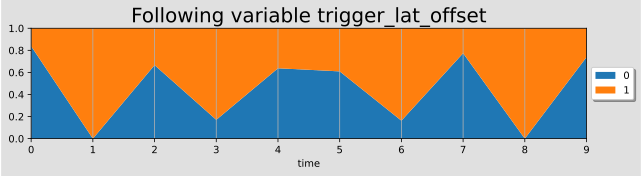

In [95]:
plt.rcParams['figure.figsize'] = (10, 2)
gdyn.plotFollow(["v_lat","steering_trigger", "trigger_lat_offset"],twodbn,T=10,evs={'v_lat2':1,'steering_trigger4':0,'steering_trigger6':0,'steering_trigger8':1,'v_lat5':1,'trigger_lat_offset8':1,'trigger_lat_offset1':1})